# Remap OSI SAF and CCI SIC CDRs

This notebook demonstrate accessing SIC CDR data from EUMETSAT OSI SAF and ESA CCI and reproject them to another grid. The remapping is based on Pytroll's pyresample. After remapping, a netCDF file is written.

We implement the mapping in several steps to try and fill as many target grid cells as possible, yet not smearing the input field too much. The exact parameters for the remapping step will have to be adapted for the various target grids.

In [1]:
import os
import xarray as xr
import numpy as np
from datetime import date, datetime, timedelta, time
from dateutil import rrule, relativedelta
import uuid
from copy import copy

import pyresample as pr

import json

from matplotlib import pylab as plt
from matplotlib import cm
from cartopy import crs as ccrs, feature as cfeature

## Configuration

In [2]:
# date to be remapped
dt = date(2003,12,2)
area = 'sh'
outdir = '.'

In [3]:
# handle datestring format and conversion
if not isinstance(dt, date):
    if isinstance(dt,str):
        if len(dt) == 6:
            dt += '16'
        if len(dt) != 8:
            raise ValueError("Datestring should br YYYYMM or YYYYMMDD")
        try:
            yyyy,mm,dd = int(dt[:4]),int(dt[4:6]),int(dt[6:8])
            dt = date(yyyy,mm,dd)
        except Exception:
            raise ValueError('Invalid datestring {}'.format(dt))

# check area parameter
if area not in ('nh', 'sh'):
    raise ValueError('Invalid hemisphere (area={})'.format(area))
    
# check outdir exists
if not os.path.exists(outdir):
    raise ValueError('Output directory does not exist ({})'.format(outdir))

In [4]:
# ID of the remapping (to appear in the resulting filename)
# netCDF CF filename that defines the target grid
if area == 'nh':
    trg_id = 'ARC11_HCLIM43_Arctic11'
    trg_file = '/home/thomasl/Downloads/lsm_clim_ARC11_HCLIM43_Arctic11_fx.nc'
else:
    trg_id = 'ANT11_ANT11'
    trg_file = '/home/thomasl/Downloads/lsm_clim_ANT11_ANT11_LD_fx.nc'

# variables holding the lat and lon
trg_latn = 'lat'
trg_lonn = 'lon'
# variable holding a landmask in the target grid
trg_lsmn = 'lsm'

# prioritization for input data source
src_prioritized_list = ['sicci-hr-sic', 'osisaf-v3',]
#src_prioritized_list = ['osisaf-v3',]

## Load the target grid and mask

In [5]:
trg_ds = xr.open_dataset(trg_file)
trg_lon = trg_ds[trg_lonn][:].to_numpy()
trg_lat = trg_ds[trg_latn][:].to_numpy()
trg_lsm = trg_ds[trg_lsmn][:].to_numpy().astype('bool')

Some printing and plotting to check things look ok

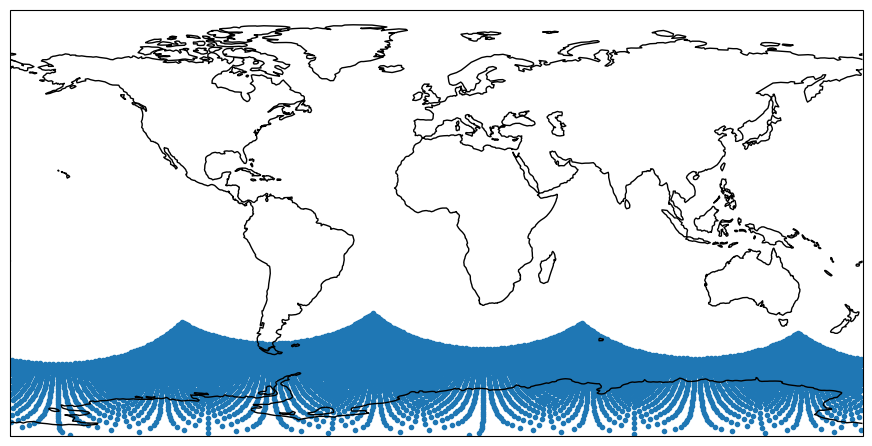

Land Sea Mask:


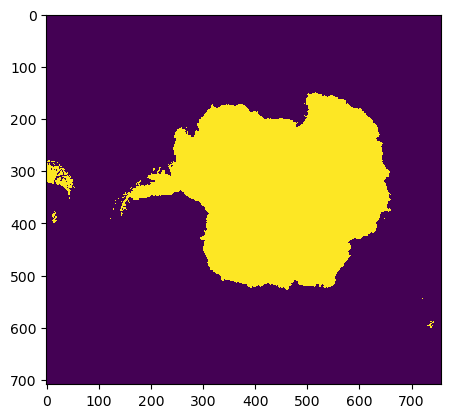

In [6]:
ev = 10
fig = plt.figure(figsize=(11, 8.5))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.scatter(trg_lon[::ev,::ev], trg_lat[::ev,::ev], marker='.', transform=ccrs.PlateCarree())
ax.set_global()
plt.show()

print("Land Sea Mask:")
plt.imshow(trg_lsm, interpolation='none')
plt.show()

In [7]:
# prepare the resampling objects
trg_geom = pr.SwathDefinition(trg_lon, trg_lat)

## Locate the OSI SAF or CCI+ CDR file to use as source

In [8]:
# First decide if the target grid covers NH or SH (TODO: handle target grids that cover both NH and SH)
trg_lat_min, trg_lat_max = trg_lat.min(), trg_lat.max()

area = []
if trg_lat_max > 0:
    area.append('nh')
if trg_lat_min < 0:
    area.append('sh')
    
if len(area) != 1:
    raise ValueError("Not supported: we currently do not support target grids that span over both NH and SH")
area = area[0]

In [9]:
# A routine to reconstruct the unfiltered, unthresholded SICs from a OSI SAF SIC CDR file
def reconstruct_sic(ds):
    ice_conc = ds['ice_conc'].to_masked_array()
    raw_ice_conc_values = ds['raw_ice_conc_values'].to_masked_array()
    status_flag = ds['status_flag'].to_masked_array().astype('short')
    
    # combine ice_conc with raw_ice_conc_values using the status_flag
    new_ice_conc = copy(ice_conc)
    raw_100_mask = np.array((ice_conc==100) * (~raw_ice_conc_values.mask))
    new_ice_conc[raw_100_mask] = raw_ice_conc_values[raw_100_mask]
    
    new_ice_conc[(status_flag & 4) == 4] = raw_ice_conc_values[(status_flag & 4) == 4]

    # re-enter "full" ice_conc into the xarray dataset
    ds['ice_conc'][:] = new_ice_conc
    return ds

def get_sic_filename(dt, area, cdr='osisaf-v3-cdr'):
    
    if cdr == 'osisaf-v3-cdr':
        fn = 'ice_conc_{a:}_ease2-250_cdr-v3p0_{d:%Y%m%d}1200.nc'.format(a=area, d=dt)
    elif cdr == 'osisaf-v3-icdr':
        fn = 'ice_conc_{a:}_ease2-250_icdr-v3p0_{d:%Y%m%d}1200.nc'.format(a=area, d=dt)
    elif cdr == 'osisaf-v3-icdrft':
        fn = 'ice_conc_{a:}_ease2-250_icdrft-v3p0_{d:%Y%m%d}1200.nc'.format(a=area, d=dt)
    elif cdr == 'osisaf-v2':
        fn = 'ice_conc_{a:}_ease2-250_cdr-v2p0_{d:%Y%m%d}1200.nc'.format(a=area, d=dt)
    elif cdr == 'osisaf-v3-amsr':
        fn = 'ice_conc_{a:}_ease2-250_cdr-v3p0-amsr_{d:%Y%m%d}1200.nc'.format(a=area, d=dt)
    elif cdr == 'sicci-hr-sic':
        fn = 'ESACCI-SEAICE-L4-SICONC-RE_SSMI_12.5kmEASE2-{a:}-{d:%Y%m%d}-fv3.0.nc'.format(a=area.upper(), d=dt)
    else:
        raise ValueError("Do not know about CDR '{}'".format(cdr))
    
    return fn

def get_sic_url(dt, area, cdr='osisaf-v3-cdr'):
    
    fn = get_sic_filename(dt, area, cdr=cdr)
    
    if cdr == 'osisaf-v3-cdr':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files'
    elif cdr == 'osisaf-v3-icdr':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files'
    elif cdr == 'osisaf-v3-icdrft':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files'
    elif cdr == 'osisaf-v2-cdr':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_v2p0_files'
    elif cdr == 'osisaf-v3-amsr':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_amsr_458_files'
    elif cdr == 'sicci-hr-sic':
        url = 'https://dap.ceda.ac.uk/thredds/dodsC/neodc/esacci/sea_ice/data/sea_ice_concentration/L4/ssmi_ssmis/12.5km/v3.0/{:}'.format(area.upper())
    else:
        raise ValueError("Do not know about CDR '{}'".format(cdr))
    
    url = os.path.join(url,'{:%Y/%m/}'.format(dt), fn)
    
    return url

def find_sic_file(dt, area, src_prioritized_list=('sicci-hr-sic', 'osisaf-v3',), verbose = False):
    
    # possibly extend the list of prioritized sources (e.g. 'osisaf-v3' calls for the ICDRs and the CDR)
    ext_src_prioritized_list = []
    for src in src_prioritized_list:
        if src == 'osisaf-v3':
            # this is calling for both the ICDRs and the CDR
            ext_src_prioritized_list.append('osisaf-v3-icdrft')
            ext_src_prioritized_list.append('osisaf-v3-icdr')
            ext_src_prioritized_list.append('osisaf-v3-cdr')
        else:
            ext_src_prioritized_list.append(src)
    
    # find the path/url to the file. There are precedence rules for what type of files
    #   to select.
    fn = None
    found_one_file = False
    for src in ext_src_prioritized_list:
        fn = get_sic_url(dt, area, cdr=src)
        if verbose:
            print("Test ", src, fn)
        try:
            # this url exists, append it and move to next date
            ds = xr.open_dataset(fn)
            found_one_file = True
            break
        except OSError:
            # no valid file at this url, check the next source in the prioritized list
            pass
        
    # no file found. Add a warning (but we can continue)
    if not found_one_file:
        fn = None
        src = None
        if verbose:
            print("WARNING: could not find SIC CDR file for {} {}".format(area, dt))
            
    return fn, src

print(get_sic_url(dt, area))
print(get_sic_url(dt, area, cdr='sicci-hr-sic'))
print(find_sic_file(dt, area, src_prioritized_list=src_prioritized_list))
print(find_sic_file(date(2023,3,31), area, src_prioritized_list=src_prioritized_list, verbose=True))

https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/2003/12/ice_conc_sh_ease2-250_cdr-v3p0_200312021200.nc
https://dap.ceda.ac.uk/thredds/dodsC/neodc/esacci/sea_ice/data/sea_ice_concentration/L4/ssmi_ssmis/12.5km/v3.0/SH/2003/12/ESACCI-SEAICE-L4-SICONC-RE_SSMI_12.5kmEASE2-SH-20031202-fv3.0.nc
('https://dap.ceda.ac.uk/thredds/dodsC/neodc/esacci/sea_ice/data/sea_ice_concentration/L4/ssmi_ssmis/12.5km/v3.0/SH/2003/12/ESACCI-SEAICE-L4-SICONC-RE_SSMI_12.5kmEASE2-SH-20031202-fv3.0.nc', 'sicci-hr-sic')
Test  sicci-hr-sic https://dap.ceda.ac.uk/thredds/dodsC/neodc/esacci/sea_ice/data/sea_ice_concentration/L4/ssmi_ssmis/12.5km/v3.0/SH/2023/03/ESACCI-SEAICE-L4-SICONC-RE_SSMI_12.5kmEASE2-SH-20230331-fv3.0.nc
Test  osisaf-v3-icdrft https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/2023/03/ice_conc_sh_ease2-250_icdrft-v3p0_202303311200.nc
Test  osisaf-v3-icdr https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_fi

## Read the SIC and prepare the remapping

In [10]:
src_file, src_id = find_sic_file(dt, area, src_prioritized_list=src_prioritized_list,)
print("Source file ({}): {}".format(src_id, src_file))
src_ds = xr.open_dataset(src_file)
src_ds = reconstruct_sic(src_ds)

src_lat = src_ds['lat'][:].to_numpy()
src_lon = src_ds['lon'][:].to_numpy()

Source file (sicci-hr-sic): https://dap.ceda.ac.uk/thredds/dodsC/neodc/esacci/sea_ice/data/sea_ice_concentration/L4/ssmi_ssmis/12.5km/v3.0/SH/2003/12/ESACCI-SEAICE-L4-SICONC-RE_SSMI_12.5kmEASE2-SH-20031202-fv3.0.nc


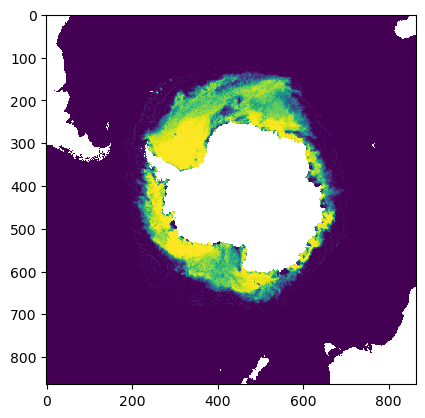

In [11]:
# quick plot to check things look ok
plt.imshow(src_ds['ice_conc'][0,:], interpolation='none', vmin=0, vmax=100)

In [12]:
# Prepare the source geometry for pyresample. It works best by removing masked values at runing to 1D
src_dat = src_ds['ice_conc'][0,:].to_masked_array()
src_flg = src_ds['status_flag'][0,:].to_numpy().astype('int16')

# remove climatological zeros (we will put them back after resampling)
src_dat[src_flg==128] = np.ma.masked

src_lon_dat = src_lon[~src_dat.mask]
src_lat_dat = src_lat[~src_dat.mask]
src_geom_dat = pr.SwathDefinition(src_lon_dat, src_lat_dat)

# Prepare the data in the same 1D shape as the src lat/lon
src_dat_1d = src_dat.compressed()

# Prepare the resampling of the flag
src_lon_flg = src_lon.flatten()
src_lat_flg = src_lat.flatten()
src_geom_flg = pr.SwathDefinition(src_lon_flg, src_lat_flg)
src_flg_1d  = src_flg.flatten()

## Perform the resampling from source to target geometry

In [13]:
# prepare the parameters to the first resampling
roi = 50000
sigma = 12500
nbgh = 8
if 'siccip-v3' in src_id:
    roi /= 3
    sigma /= 3

In [14]:
# Do a first remapping:
#  we remap the SICs and specify an un-physical value for the fill_value, which will appear where
#  target grid cells have no close-enough source values for the resampling. We will have to deal
#  with these cells separately.
fill_value = 500
trg_dat = pr.kd_tree.resample_gauss(src_geom_dat, src_dat_1d, trg_geom,
                                    radius_of_influence=roi, sigmas=sigma, neighbours=nbgh,
                                    fill_value=fill_value)

trg_flg = pr.kd_tree.resample_nearest(src_geom_flg, src_flg_1d, trg_geom,
                                    radius_of_influence=roi)

trg_dat = np.ma.array(trg_dat)
# apply the target land-sea mask
trg_dat[trg_lsm] = np.ma.masked
trg_flg[trg_lsm] = 1

# apply the resampled max extent climatology
trg_dat[trg_flg == 128] = 0


/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/pyresample/kd_tree.py:259: UserWarning: Possible more than 8 neighbours within 50000 m for some data points
  get_neighbour_info(source_geo_def,


Iter 1: Attempt to fill 277 gaps.


/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/pyresample/kd_tree.py:259: UserWarning: Possible more than 12 neighbours within 75000 m for some data points
  get_neighbour_info(source_geo_def,


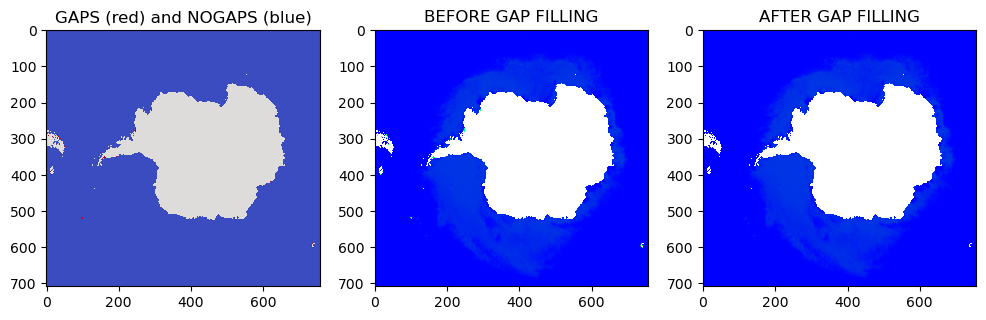

Iter 2: Attempt to fill 1 gaps.


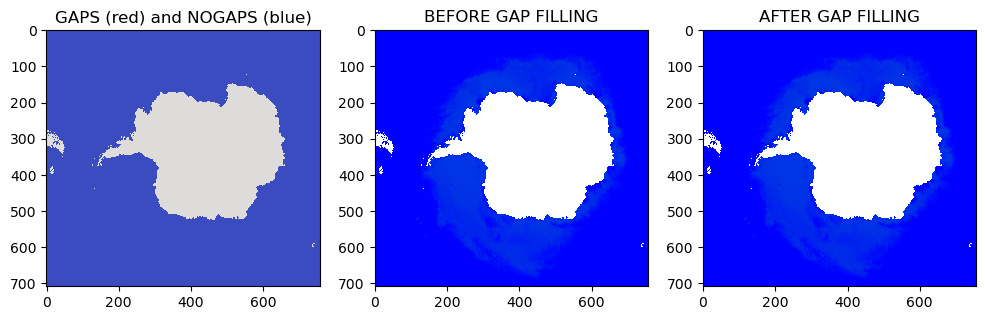

After 2 remappings, there are 0 gaps left.


In [15]:
# prepare the parameters to the second resampling
roi = 75000
sigma = 25000
nbgh = 12

# Do a second remapping:
#   remap the remaining "fill_value" cells that are not over the target land (as given by trg_lsm)

gapfill_iter = 0
nb_fill_value = (trg_dat==fill_value).sum()
while nb_fill_value > 0 and gapfill_iter < 10:
    print("Iter {}: Attempt to fill {} gaps.".format(gapfill_iter+1, nb_fill_value))
    # define the gaps
    trg_gaps = (trg_dat==fill_value)
    trg_gaps_lat = trg_lat[trg_gaps]
    trg_gaps_lon = trg_lon[trg_gaps]
    trg_gaps_geom = pr.SwathDefinition(trg_gaps_lon, trg_gaps_lat)

    # define the nogaps
    trg_nogaps = (trg_dat!=fill_value).filled(False)
    trg_nogaps_lat = trg_lat[trg_nogaps]
    trg_nogaps_lon = trg_lon[trg_nogaps]
    trg_nogaps_geom = pr.SwathDefinition(trg_nogaps_lon, trg_nogaps_lat)
    trg_nogaps_data = trg_dat[trg_nogaps].compressed()
 
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,3,1)
    ax.imshow(np.ma.array(trg_gaps,mask=~trg_gaps), cmap=cm.coolwarm, vmin=-1, vmax=+1, interpolation='none')
    ax.imshow(-1*np.ma.array(trg_nogaps,mask=~trg_nogaps), cmap=cm.coolwarm, vmin=-1, vmax=+1, interpolation='none')
    ax.imshow(0*np.ma.array(trg_lsm,mask=~trg_lsm), cmap=cm.coolwarm, vmin=-1, vmax=+1, interpolation='none')
    ax.set_title('GAPS (red) and NOGAPS (blue)')
    ax = fig.add_subplot(1,3,2)
    ax.imshow(trg_dat, interpolation='none', vmin=0, vmax=fill_value, cmap=cm.winter)
    ax.set_title('BEFORE GAP FILLING')

    
    # do the remapping of no gaps to gaps
    trg_gaps_dat = pr.kd_tree.resample_gauss(trg_nogaps_geom, trg_nogaps_data, trg_gaps_geom,
                                        radius_of_influence=roi, sigmas=sigma, neighbours=nbgh,
                                        fill_value=fill_value)
    
    # reassign the interpolated gaps in the original array, record the interpolation with
    #   a status flag value
    trg_dat[trg_gaps] = trg_gaps_dat
    trg_flg[trg_gaps] = 32

    ax = fig.add_subplot(1,3,3)
    ax.imshow(trg_dat, interpolation='none', vmin=0, vmax=fill_value, cmap=cm.winter)
    ax.set_title('AFTER GAP FILLING')
    plt.show()
    
    # update the counter of missing data
    nb_fill_value = (trg_dat==fill_value).sum()
    gapfill_iter += 1
    
print("After {} remappings, there are {} gaps left.".format(gapfill_iter, nb_fill_value))

# These gaps we could not fill, turn them back to masked value, and record in the status_flag
trg_gaps = (trg_dat==fill_value)
trg_flg[trg_gaps] = 256
trg_dat[trg_gaps] = np.ma.masked

In [16]:
# apply the resampled open water mask and threshold at > 100 and < 0
trg_dat[(trg_flg & 4)==4] = 0
trg_dat[trg_dat>100] = 100
trg_dat[trg_dat<0] = 0

## Some plots to check things look good in the target geometry

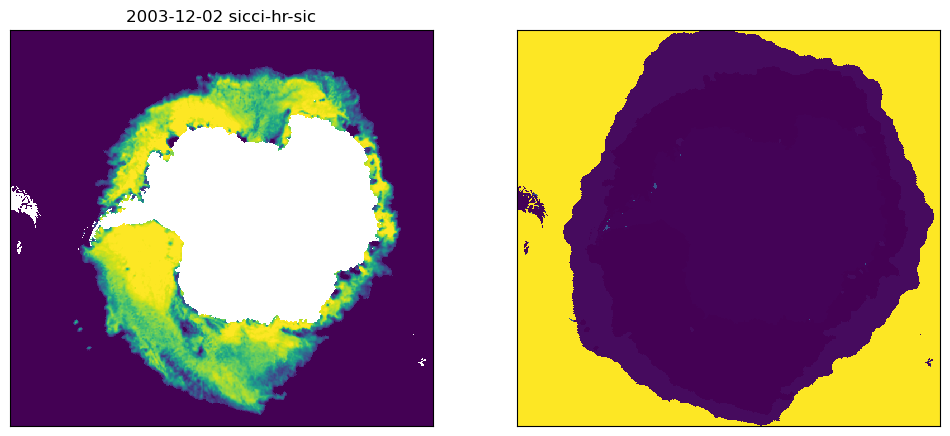

In [17]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.imshow(trg_dat, interpolation='none',vmin=0, vmax=100)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('{} {}'.format(dt, src_id))
ax = fig.add_subplot(1,2,2)
ax.imshow(trg_flg, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

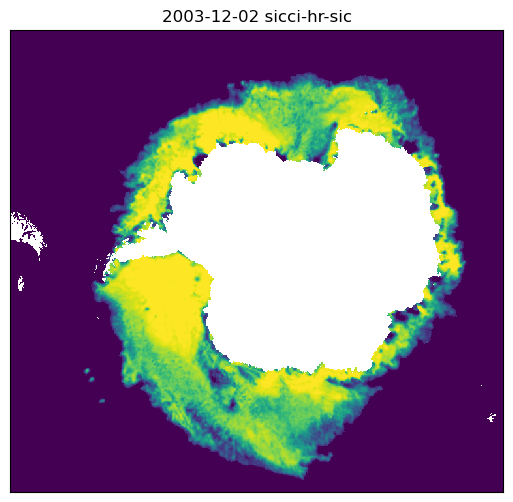

In [18]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.imshow(trg_dat, interpolation='none',vmin=0, vmax=100)
ax.set_title('{} {}'.format(dt, src_id))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Prepare a netCDF file with the resampled field

We first prepare an xarray dataset, then write it to netCDF. We start from the template of the "ice_conc" variable in the source file and transfer variables and dimensions from the target file.

In [19]:
trg_ds = xr.open_dataset(trg_file, mask_and_scale=False, decode_times=False)
src_ds = xr.open_dataset(src_file, mask_and_scale=False, decode_times=False)

In [20]:
# crs_name for the target file
crs_n = trg_ds[trg_lsmn].attrs['grid_mapping']

In [21]:
# Prepare data variables
ice_conc = trg_dat[None,:,:]
sflags = trg_flg[None,:,:]
out_dat={crs_n: (trg_ds[crs_n].dims, trg_ds[crs_n].to_numpy(), trg_ds[crs_n].attrs),
         'ice_conc':( src_ds['ice_conc'].dims, ice_conc, \
                     {a: src_ds['ice_conc'].attrs[a] for a in ('standard_name', 'long_name', 'comment', 'units', 'valid_min', 'valid_max', )}),
         'status_flag': (src_ds['status_flag'].dims, sflags, \
                     {a: src_ds['status_flag'].attrs[a] for a in ('standard_name', 'long_name', 'comment', 'valid_min', 'valid_max', \
                                                               'flag_masks', 'flag_meanings', 'flag_descriptions')}),
         'time_bnds':( src_ds['time_bnds'].dims, src_ds['time_bnds'].to_numpy(), None)
        }

# assign the grid_mapping variable to the new name of the crs
for v in ('ice_conc', 'status_flag'):
    out_dat[v][-1]['grid_mapping'] = crs_n
    
# add a status_flag entry for the remaining gaps we could not fill
out_dat['status_flag'][-1]['flag_masks'] = np.append(out_dat['status_flag'][-1]['flag_masks'],[256,])
out_dat['status_flag'][-1]['flag_meanings'] = out_dat['status_flag'][-1]['flag_meanings']+' missing_data'
out_dat['status_flag'][-1]['flag_descriptions'] = out_dat['status_flag'][-1]['flag_descriptions'] + \
    '\nbit 9 (flag 256): no SIC given because of non-interpolated missing data.'

# Prepare coordinates: we transfer the values of the target coordinates into
#    the structure of the source coordinates.
out_coords = {'time': src_ds.coords['time'],}
for trg_coord in trg_ds[trg_lsmn].coords:
    coord_n = trg_coord
    if coord_n in ('x', 'y'):
        coord_n += 'c'
    out_coords[coord_n] = (src_ds[coord_n].dims, trg_ds[trg_coord][:].to_numpy(), \
                           {a: src_ds[coord_n].attrs[a] for a in ('standard_name','units', 'long_name')})
    
# Prepare the (global) attributes
out_attrs = src_ds.attrs

# Create the output xarray dataset from the above elements
out_ds = xr.Dataset(out_dat, out_coords, out_attrs)

In [22]:
# Work on the encoding of the fields for writing to netCDF4

# global attributes
out_ds.attrs['title'] = "Regridded " + out_ds.attrs['title']

# below would be better handled if we had accessed to an AreaDefinition object
out_ds.attrs['geospatial_lat_min'] = trg_lat.min()
out_ds.attrs['geospatial_lat_max'] = trg_lat.max()
out_ds.attrs['geospatial_lon_min'] = trg_lon.min()
out_ds.attrs['geospatial_lon_max'] = trg_lon.max()
del out_ds.attrs['spatial_resolution']
del out_ds.attrs['geospatial_bounds_crs']

now = datetime.utcnow().replace(microsecond=0)
out_ds.attrs['history'] += '\n' + now.isoformat()+'Z' + ' regridding to {}'.format(crs_n)
out_ds.attrs['date_created'] = now.date().isoformat()
out_ds.attrs['tracking_id'] = str(uuid.uuid4())
for a in ('doi', 'id', 'naming_authority'):
    try:
        del out_ds.attrs[a]
    except:
        pass

# encoding
encoding = {'ice_conc': {'dtype':src_ds['ice_conc'].dtype, 'scale_factor':src_ds['ice_conc'].scale_factor, '_FillValue':src_ds['ice_conc']._FillValue,},
            'status_flag': {'dtype':src_ds['status_flag'].dtype, '_FillValue':src_ds['status_flag']._FillValue},
            'time': {'_FillValue':None}, 'time_bnds': {'_FillValue':None},
            'lat': {'_FillValue':None}, 'lon': {'_FillValue':None},
            'xc': {'_FillValue':None}, 'yc': {'_FillValue':None}}

for v in encoding.keys():
    encoding[v]['zlib']=True

In [23]:
# Write to netCDF file

out_n = os.path.basename(src_file)
if 'siccip-v3' in src_id:
    out_n = out_n.replace('-NH-', '-')
    out_n = out_n.replace('-SH-', '-')
elif 'osisaf' in src_id:
    out_n = out_n.replace('_nh_', '_')
    out_n = out_n.replace('_sh_', '_')
out_n = out_n.replace('.nc', '_{}.nc'.format(trg_id.replace('_','-')))
out_n = os.path.join(outdir, out_n)

if os.path.exists(out_n):
    os.remove(out_n)

out_ds.to_netcdf(out_n, encoding=encoding, format='NETCDF4_CLASSIC')
print(out_n + " is ready.")

./ESACCI-SEAICE-L4-SICONC-RE_SSMI_12.5kmEASE2-SH-20031202-fv3.0_ANT11-ANT11.nc is ready.
